### pip installations

In [230]:
import numpy as np
# import starfysh
import pandas as pd
import scanpy as sc
import seaborn as sns
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
# !pip install starfysh
# !pip install pandas 
# !pip install scanpy
# !pip install histomicstk
# !pip install --upgrade pip setuptools wheel
# !pip install pyvips --use-pep517
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import bar_nick_utils
import importlib

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, get_cell_representations_as_archetypes, preprocess_protein, plot_archetypes
# computationally figure out which ones are best
np.random.seed(8)

### reading in data

In [108]:
adata = sc.read("data/totalVI/spleen_lymph_cite_seq.h5ad")
adata = adata[adata.obs['batch'] == f'SLN111-D1']
# take subsampel of adata
fraction = 1.
sc.pp.subsample(adata, fraction=fraction)
adata.obsm['protein_expression'].columns.tolist()

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['ADT_CD102_A0104',
 'ADT_CD103_A0201',
 'ADT_CD106_A0226',
 'ADT_CD115(CSF-1R)_A0105',
 'ADT_CD117(c-Kit)_A0012',
 'ADT_CD11a_A0595',
 'ADT_CD11c_A0106',
 'ADT_CD122(IL-2Rb)_A0227',
 'ADT_CD127(IL-7Ra)_A0198',
 'ADT_CD134(OX-40)_A0195',
 'ADT_CD135_A0098',
 'ADT_CD137_A0194',
 'ADT_CD14_A0424',
 'ADT_CD140a_A0573',
 'ADT_CD15(SSEA-1)_A0076',
 'ADT_CD150(SLAM)_A0203',
 'ADT_CD16-32_A0109',
 'ADT_CD169(Siglec-1)_A0440',
 'ADT_CD172a(SIRPa)_A0422',
 'ADT_CD183(CXCR3)_A0228',
 'ADT_CD184(CXCR4)_A0444',
 'ADT_CD19_A0093',
 'ADT_CD192(CCR2)_A0426',
 'ADT_CD195(CCR5)_A0376',
 'ADT_CD196(CCR6)_A0225',
 'ADT_CD197(CCR7)_A0377',
 'ADT_CD20_A0192',
 'ADT_CD200(OX2)_A0079',
 'ADT_CD201(EPCR)_A0439',
 'ADT_CD204(Msr1)_A0448',
 'ADT_CD206(MMR)_A0173',
 'ADT_CD21-CD35(CR2-CR1)_A0107',
 'ADT_CD223(LAG-3)_A0378',
 'ADT_CD23_A0108',
 'ADT_CD24_A0212',
 'ADT_CD25_A0097',
 'ADT_CD274(B7-H1_PD-L1)_A0190',
 'ADT_CD278(ICOS)_A0171',
 'ADT_CD279(PD-1)_A0004',
 'ADT_CD28_A0204',
 'ADT_CD29_A0570',
 'ADT_CD300

In [109]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

In [110]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        4459
CD4 T          1892
CD8 T          1432
T cells         219
cDCs            181
Treg            151
Monocytes        99
Macrophages      95
NK               82
Neutrophils      53
pDCs             41
RBC              32
Name: count, dtype: int64

In [111]:
# filtering cell types with low quantity
# need to add this filtering step to synthtic_data_generation.ipynb

# mask = adata.obs['major_cell_types'].isin(['Plasmacytoid dendritic cells', 'Red blood cells', 'Dendritic cells'])
# adata = adata[~mask]


In [112]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        4459
CD4 T          1892
CD8 T          1432
T cells         219
cDCs            181
Treg            151
Monocytes        99
Macrophages      95
NK               82
Neutrophils      53
pDCs             41
RBC              32
Name: count, dtype: int64

### starfysh analysis does not work

### using PCHA

### preprocessing rna

In [113]:
adata = preprocess_rna(adata, adata)

### preprocessing protein

In [114]:
adata.obsm['protein_expression'].shape
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
# assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
adata_rna.obsm.pop('protein_expression')
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch 
# larget_batch = adata_prot.obs['batch'].value_counts().idxmax()

In [115]:
adata_prot = preprocess_protein(adata_prot)

In [116]:
adata = adata_prot

### analysis to get to scatter plot

In [117]:
adata

AnnData object with n_obs × n_vars = 8736 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'n_cells'

In [118]:
sc.pp.pca(adata, n_comps=30)

In [119]:
count = adata.obsm['X_pca']

In [120]:
# converge=1e-3
# for i, k in enumerate(range(2, 4, 2)):
#     archetype, _, _, _, ev = PCHA(X, noc=13)
#     evs.append(ev)
#     
# .append(np.array(archetype).T)
#     if i > 0 and ev - evs[i-1] < converge:
#         # early stopping
#         break

In [121]:

X = count.T
archetype, _, _, _, ev = PCHA(X, noc=len(set(adata.obs['major_cell_types'])))
# archetype = archetype.T
archetype.shape

(30, 12)

In [122]:
# # weights = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes[-1].T)
# distances_array = []
# for arche in archetype:
#     distances = np.linalg.norm(adata_prot.obsm['X_pca']- arche, axis=1)
#     distances_array.append(distances)
# # np.linalg.norm(adata.obsm['X_pca'],archetype.T)
#     
# 
# # Columns: Cell 1 Cell 2 Cell 3 Cell 4
# # Row: anchor 
# # column, row distance from cell to anchor
# # we want minimum
# distances_array = np.array(distances_array)
# distances_array = distances_array.T
# row_argmin = np.argmin(distances_array, axis=1)
# adata.obs['archetype'] = row_argmin

### weights

In [123]:
# send this for gene and protein as well as matching arrays over slack
weights = get_cell_representations_as_archetypes(adata.obsm['X_pca'], archetype.T)
weights_df = pd.DataFrame(weights)
weights_df.to_csv("rna_weights.csv")
row_argmax = np.argmax(weights, axis=1)
adata.obs['corr_archetype'] = row_argmax
len(set((adata.obs['major_cell_types'])))


12

In [124]:
# identifying specific "cell type" we want

archetype_proportion_list = []
for desired_cell_type in range(len(set(adata.obs['major_cell_types']))):
    arr = []
    for idx, val in enumerate(row_argmax):
        if val == desired_cell_type:
            arr.append(idx)

    adata_slice = adata[arr,]
    archetype_proportion = adata_slice.obs['major_cell_types'].value_counts().to_dict()
    for key in archetype_proportion:
        archetype_proportion[key] = archetype_proportion[key] / len(adata_slice)

    archetype_proportion_list.append(archetype_proportion)


In [125]:
adata_slice = adata[arr,]
adata_slice.shape

(163, 110)

In [126]:
adata.obs['cell_types']

index
CCATAAGTCATGCGGC-1          Mature B
TATCCTATCTTAATCC-1    Transitional B
GAAATGATCATTACCT-1          Mature B
TCATTCATCTGTTCAT-1      CD122+ CD8 T
AGGAATACAGCCGGTT-1             CD4 T
                           ...      
GACCGTGCAACCCTAA-1          Mature B
TGGTAGTCACAAATAG-1     Migratory DCs
GCAGTTATCTCGCCTA-1             CD4 T
CGAGGCTTCAACCTCC-1             CD8 T
CATGCCTAGTAGCAAT-1      CD122+ CD8 T
Name: cell_types, Length: 8736, dtype: category
Categories (27, object): ['Activated CD4 T', 'B1 B', 'CD122+ CD8 T', 'CD4 T', ..., 'Tregs', 'cDC1s', 'cDC2s', 'pDCs']

In [127]:
# set(list(adata.obs['major_cell_types']))
(set(cell_type_mapping.keys())) == ((set(adata.obs['cell_types'])))

True

In [128]:
# once I have indices, I want to check cell type for all of the indices
for dictionary in archetype_proportion_list:
    print(dictionary)


{'B cells': 0.9675036927621861, 'RBC': 0.022156573116691284, 'CD4 T': 0.0029542097488921715, 'Neutrophils': 0.0029542097488921715, 'Macrophages': 0.0014771048744460858, 'NK': 0.0014771048744460858, 'cDCs': 0.0014771048744460858}
{'CD8 T': 0.9728978457261988, 'T cells': 0.01389854065323141, 'cDCs': 0.007644197359277276, 'RBC': 0.0020847810979847115, 'B cells': 0.001389854065323141, 'Treg': 0.001389854065323141, 'pDCs': 0.0006949270326615705}
{'B cells': 0.6909090909090909, 'Macrophages': 0.24727272727272728, 'cDCs': 0.01818181818181818, 'Neutrophils': 0.014545454545454545, 'pDCs': 0.01090909090909091, 'CD4 T': 0.007272727272727273, 'Monocytes': 0.007272727272727273, 'T cells': 0.0036363636363636364}
{'T cells': 0.2676056338028169, 'Monocytes': 0.2605633802816901, 'Neutrophils': 0.2112676056338028, 'pDCs': 0.09154929577464789, 'NK': 0.07042253521126761, 'cDCs': 0.035211267605633804, 'CD4 T': 0.028169014084507043, 'Treg': 0.02112676056338028, 'B cells': 0.007042253521126761, 'CD8 T': 0.00

In [129]:
# gene protein mapping
gene_mapping = ['Monocytes', 'T cells-2', 'T cells-1', 'Macrophages', 'Neutrophils', 'Red blood cells',
                'Natural killer cells', 'Conventional dendritic cells', 'Regulatory T cells', 'Dendritic cells',
                'Natural killer T cells', 'Plasmacytoid dendritic cells', 'B cells']

In [130]:
# final protein mapping
protein_mapping = ['Red blood cells', 'T cells-2', 'Plasmacytoid dendritic cells', 'Natural killer T cells',
                   'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes',
                   'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [131]:
assert len(protein_mapping) == len(set(protein_mapping))

In [132]:
# protein_mapping = ['Red blood cells', 'Natural killer T cells', 'T cells-2', 'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [133]:
# MUST SAVE
# protein_mapping = ['Red blood cells','Plasmacytoid dendritic cells', 'T cells-2','Natural killer cells', 'Natural killer T cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells','B cells', 'T cells-1' ]

print(len(set(list(protein_mapping))))

13


In [134]:
# Plasmacytoid dendritic cells

In [135]:
for i in set(adata.obs['major_cell_types']):
    if i not in gene_mapping:
        print(i)
# print(len(protein_mapping))
# print(len(set(protein_mapping)))

CD8 T
pDCs
CD4 T
NK
cDCs
RBC
T cells
Treg


In [136]:
# former rna_mapping = ["Monoctyes",'T cells-2', 'T cells-1', 'Macrophages', 'Neutrophils', 'B cells' , 'Natural killer cells','Conventional dendritic cells', 'Regulatory T cells', 'Dendritic cells', 'Natural killer T cells', 'Plasmacytoid dendritic cells', 'B cells' ]

In [137]:
# print(len(set(rna_mapping)))

In [138]:
cell_type_mapping_order = sorted(set(cell_type_mapping.values()))  # order that we set dimensions

In [139]:
adata[arr, :]

View of AnnData object with n_obs × n_vars = 163 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'corr_archetype'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [140]:
x = adata.obsm['X_pca'][:, :2]
y = x[arr, :]

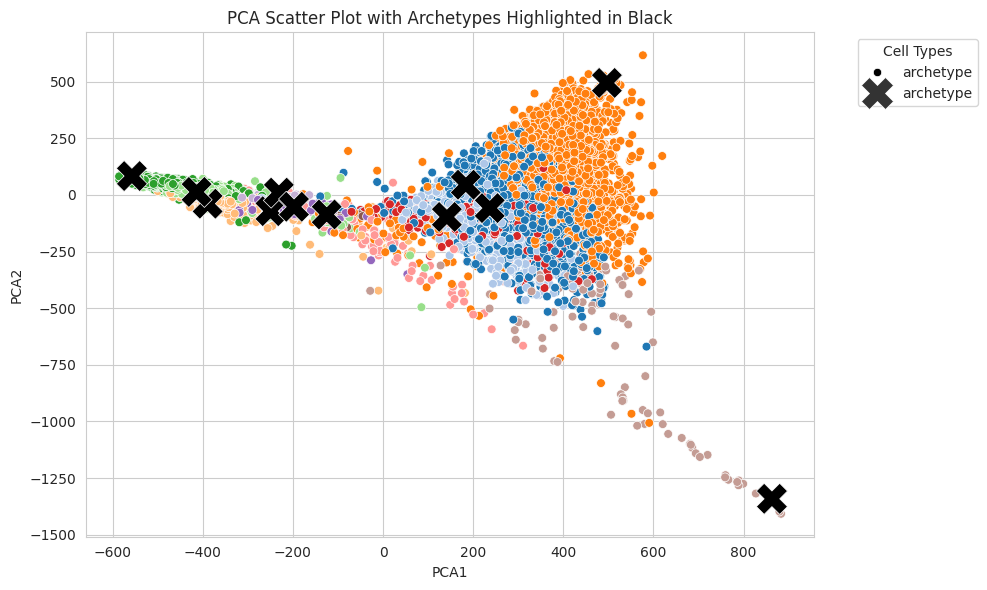

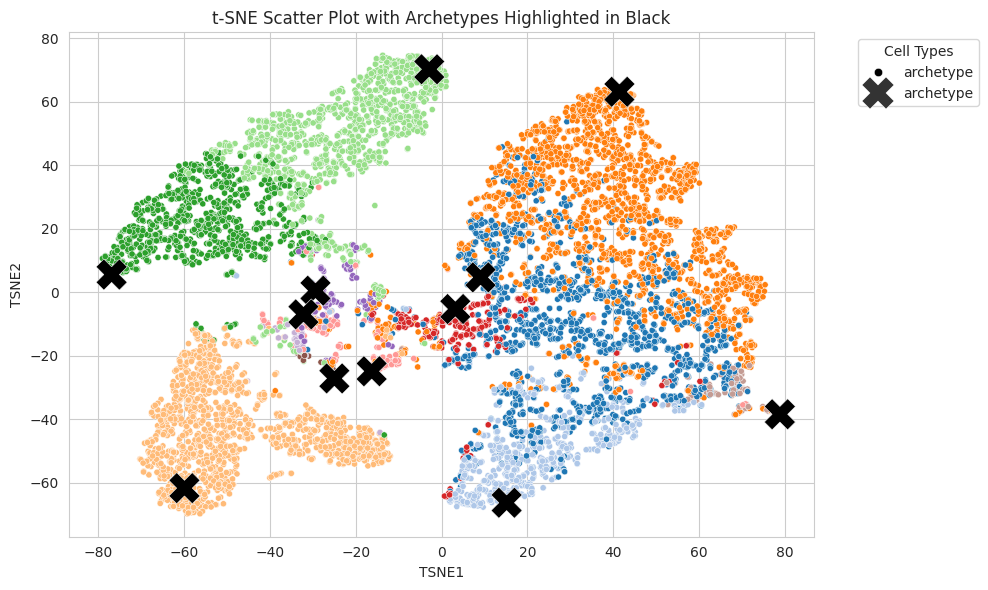

In [233]:
data_points = adata.obsm['X_pca']
samples_cell_types = list(pd.Categorical(adata.obs['cell_types']))
samples_cell_types = list(pd.Categorical(adata.obs['major_cell_types']))
samples_cell_types = list(adata.obs['corr_archetype']) #  to see the most correlated cells to each archetype
plot_archetypes(data_points,archetype,samples_cell_types)


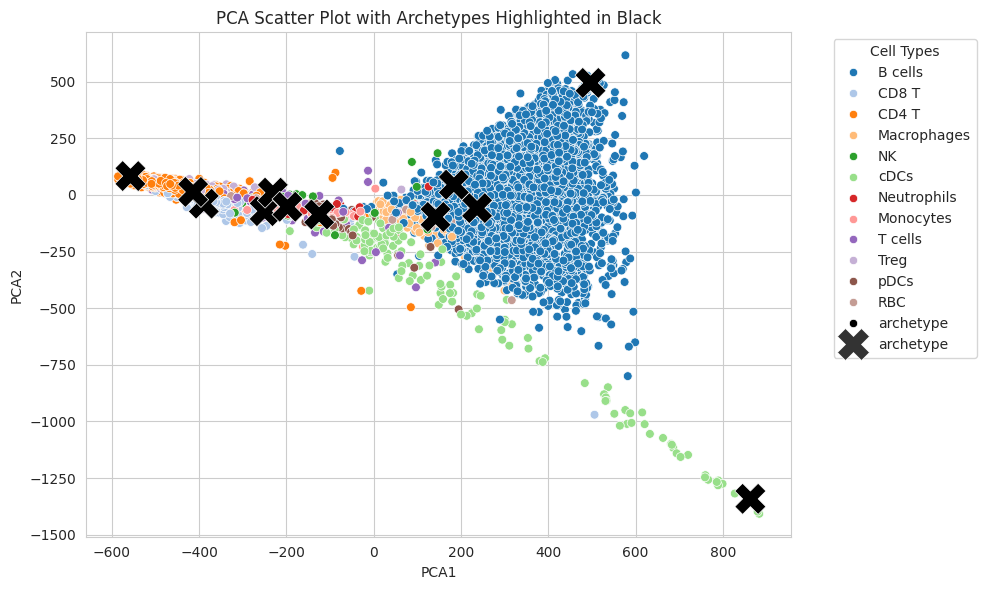

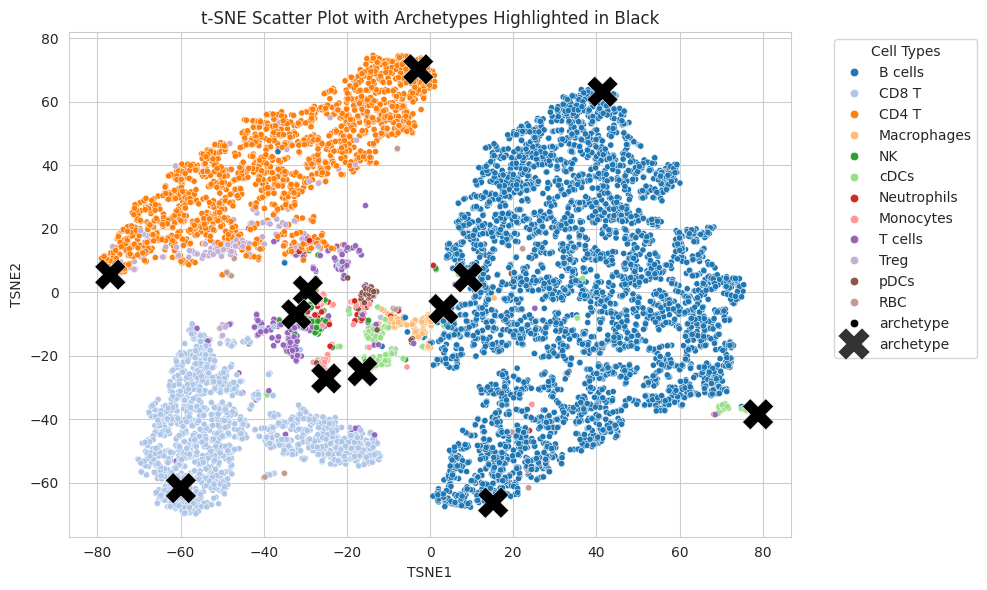

In [ ]:
# sc.pl.pca(adata, color='major_cell_types')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
# adata.obs['archetype'] = pd.Categorical(adata.obs['archetype'])
adata.obs['corr_archetype'] = pd.Categorical(adata.obs['corr_archetype'])
sc.pl.umap(adata, color=['major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.pca(adata, color=['archetype', 'major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.umap(adata, color='major_cell_types', title='Protein Major Cell Types')

In [ ]:
sc.pl.umap(adata, color='cell_types', title='Protein Minor Cell Types')

In [ ]:
archetypes[-1].shape
# two samples, first dimension: x, second dimension: y

In [ ]:
sc.pl.pca(adata_slice, color='')

In [ ]:
adata.uns['cell_types'] = adata.obs['cell_types']

In [ ]:
adata.uns['cell_types']